# Reproducing Figure 2 from Gal and Ghahramani (2016)

This notebook reproduces Figure 2 from the paper:

**Dropout as a Bayesian Approximation: Representing Model Uncertainty in Deep Learning**  
Yarin Gal and Zoubin Ghahramani, ICML 2016  
[arXiv:1506.02142](https://arxiv.org/abs/1506.02142)


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor


In [2]:
import requests
import io

url = "https://gml.noaa.gov/webdata/ccgg/trends/co2/co2_mm_mlo.txt"

def load_co2_data(url):
    response = requests.get(url)
    data_str = response.text
    df = pd.read_csv(io.StringIO(data_str), 
                     delim_whitespace=True, 
                     comment='#',
                     header=None,
                     names=['year', 'month', 'decimal_date', 'average', 'interpolated', 'trend', 'days'])
    df = df[df['average'] != -99.99]
    return df

df = load_co2_data(url)
df = df[['decimal_date', 'average']]
df.head()

/var/folders/1r/qsm406yn7ggg3tk0c4nl_y_m0000gn/T/ipykernel_92155/3812060710.py:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(io.StringIO(data_str),


,decimal_date,average
1958,315.71,314.44
1958,317.45,315.16
1958,317.51,314.69
1958,317.27,315.15
1958,315.87,315.20


In [3]:
X = df['decimal_date'].values.reshape(-1, 1)
y = df['average'].values.reshape(-1, 1)
X = (X - X.mean()) / X.std()
y = (y - y.mean()) / y.std()
scaler_x = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_x.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)
from sklearn.preprocessing import MinMaxScaler

scaler_x = MinMaxScaler()
X_scaled = scaler_x.fit_transform(X) 

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, shuffle=False, test_size=0.2)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

In [4]:
from sklearn.gaussian_process.kernels import Kernel, RBF, WhiteKernel, ConstantKernel as C
import numpy as np

class MaskedWhiteNoiseKernel(Kernel):
    def __init__(self, base_kernel, noise_level=1e-1, threshold=0.1, training_data=None):
        self.base_kernel = base_kernel
        self.noise_level = noise_level
        self.threshold = threshold
        self.training_data = training_data  

    def __call__(self, X, Y=None, eval_gradient=False):
        # base RBF kernel
        K = self.base_kernel(X, Y, eval_gradient=eval_gradient)

        if eval_gradient:
            K_mat, K_grad = K
        else:
            K_mat = K

        # distance to the nearest training point
        from scipy.spatial.distance import cdist
        if self.training_data is None:
            raise ValueError("You must set training_data before using the kernel.")
        
        dX = np.min(cdist(X, self.training_data), axis=1)
        dY = dX if Y is None else np.min(cdist(Y, self.training_data), axis=1)

        # compute noise mask (1 if far, 0 if close)
        mask = np.outer(dX > self.threshold, dY > self.threshold).astype(float)
        noise_matrix = self.noise_level * np.eye(len(X)) if Y is None else np.zeros((len(X), len(Y)))
        K_masked = K_mat + mask * noise_matrix

        if eval_gradient:
            return K_masked, K_grad
        else:
            return K_masked

    def diag(self, X):
        return np.diag(self.__call__(X))

    def is_stationary(self):
        return False

In [67]:
class MLPStandard(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1)
        )

    def forward(self, x):
        return self.net(x)

class MLPDropout(nn.Module):
    def __init__(self, p=0.05, activation='tanh'):
        super(MLPDropout, self).__init__()
        self.dropout = nn.Dropout(p)

        self.activation = torch.tanh if activation == 'tanh' else F.relu

        self.fc1 = nn.Linear(1, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 64)
        self.fc5 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.activation(self.fc2(x))
        x = self.dropout(x)
        x = self.activation(self.fc3(x))
        x = self.dropout(x)
        x = self.activation(self.fc4(x))
        x = self.dropout(x)
        x = self.fc5(x)
        return x
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=0.5, length_scale_bounds=(1e-2, 1e2)) + WhiteKernel(noise_level=1e-5)
gp = GaussianProcessRegressor(kernel=kernel, optimizer=None, alpha=0.1)  
gp.fit(X_train, y_train.ravel())

# GP predictions on X_scaled
y_pred_gp_scaled, y_std_gp_scaled = gp.predict(X_scaled, return_std=True)

# reshape and inverse transform for the predictions
y_pred_gp = scaler_y.inverse_transform(y_pred_gp_scaled.reshape(-1, 1))

# scaling on std (vector 1D)
y_std_gp = y_std_gp_scaled.reshape(-1, 1) * scaler_y.scale_

In [68]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from tqdm import trange

def init_weights_uniform(m):
    if isinstance(m, nn.Linear):
        fan_in = m.weight.size(1)
        bound = 3.0 / fan_in
        nn.init.uniform_(m.weight, -bound, bound)
        nn.init.constant_(m.bias, 0.0)

def train_custom(
    model,
    X,
    y,
    base_lr=0.01,
    gamma=0.0001,
    p=0.25,
    iterations=10000,
    batch_size=32,
    weight_decay=1e-6,
    momentum=0.9
):
    model.apply(init_weights_uniform)  # custom weight init
    model.train()

    dataset = TensorDataset(X, y)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    optimizer = torch.optim.SGD(
        model.parameters(),
        lr=base_lr,
        momentum=momentum,
        weight_decay=weight_decay
    )
    loss_fn = nn.MSELoss()

    # we loop through batches for iterations times 
    data_iter = iter(data_loader)

    for iter_num in trange(iterations):
        try:
            X_batch, y_batch = next(data_iter)
        except StopIteration:
            # we restart the data loader iterator when epoch ends
            data_iter = iter(data_loader)
            X_batch, y_batch = next(data_iter)

        lr = base_lr * (1 + gamma * iter_num) ** (-p)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

        optimizer.zero_grad()
        output = model(X_batch)
        loss = loss_fn(output, y_batch)
        loss.backward()
        optimizer.step()

In [60]:
# standard MLP
model_std = MLPStandard()
train_custom(model_std, X_train_tensor, y_train_tensor)

# MLP with ReLU + dropout
model_relu = MLPDropout(p=0.25, activation='relu')
train_custom(model_relu, X_train_tensor, y_train_tensor)

# MLP with Tanh + dropout
model_tanh = MLPDropout(p=0.05, activation='tanh')
train_custom(model_tanh, X_train_tensor, y_train_tensor)

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:04<00:00, 2273.44it/s]


In [69]:
import torch

def predict_mc(model, X, T=1000):
    model.train()  # dropout at test time
    preds = []

    with torch.no_grad():
        for _ in range(T):
            preds.append(model(X).cpu().numpy())  # we collect predictions

    preds = np.stack(preds, axis=0) 
    mean = preds.mean(axis=0).squeeze() 
    std = preds.std(axis=0).squeeze()  
    return mean, std

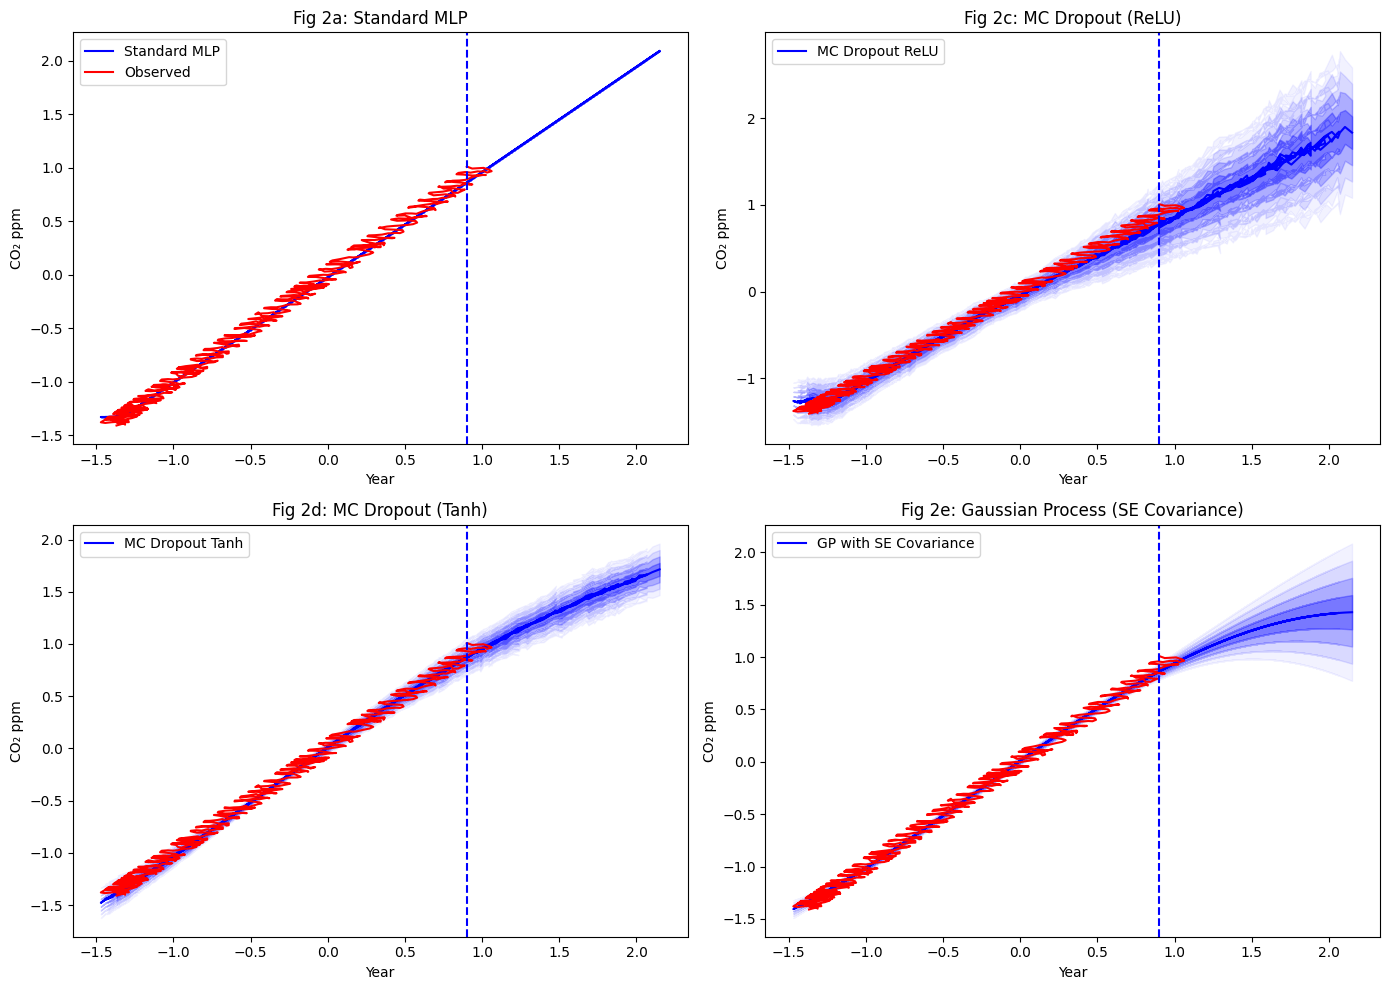

In [70]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def plot_model(ax, model, X_all_tensor, label, color, use_mc=False, T=100):
    if use_mc:
        mean, std = predict_mc(model, X_all_tensor, T)
    else:
        model.eval()
        with torch.no_grad():
            mean = model(X_all_tensor).cpu().numpy()
            std = np.zeros_like(mean)

    mean_inv = scaler_y.inverse_transform(mean.reshape(-1, 1))
    std_inv = scaler_y.scale_ * std 
    x_axis = scaler_x.inverse_transform(X_all_tensor.numpy())
    mean_inv = scaler_y.inverse_transform(mean.reshape(-1, 1)).flatten()
    std_inv = std.reshape(-1, 1) * scaler_y.scale_
    std_inv = std_inv.flatten()
    ax.plot(x_axis, mean_inv, label=label, color=color)

    # layered uncertainty bands 
    alphas = [0.3, 0.2, 0.1, 0.05]
    for i, k in enumerate([0.5, 1.0, 1.5, 2.0]):
        ax.fill_between(
            x_axis.flatten(),
            (mean_inv - k * std_inv).flatten(),
            (mean_inv + k * std_inv).flatten(),
            color=color,
            alpha=alphas[i]
        )

def plot_gp(ax, x_scaled, y_pred, y_std, label, color):
    x_axis = scaler_x.inverse_transform(x_scaled)
    ax.plot(x_axis, y_pred, label=label, color=color)

    # layered uncertainty bands
    alphas = [0.3, 0.2, 0.1, 0.05]
    for i, k in enumerate([0.5, 1.0, 1.5, 2.0]):
        ax.fill_between(
            x_axis.flatten(),
            (y_pred - k * y_std).flatten(),
            (y_pred + k * y_std).flatten(),
            color=color,
            alpha=alphas[i]
        )

X_all_tensor = torch.tensor(X_scaled, dtype=torch.float32)

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

# plot: Standard MLP
plot_model(axs[0], model_std, X_all_tensor, "Standard MLP", "blue")
axs[0].plot(X[:len(y_train)], y[:len(y_train)], color='red', label='Observed')
axs[0].axvline(x=scaler_x.inverse_transform(X_train[-1].reshape(1, -1)), linestyle='--', color='blue')
axs[0].set_title("Fig 2a: Standard MLP")

# plot: MC Dropout ReLU
plot_model(axs[1], model_relu, X_all_tensor, "MC Dropout ReLU", "blue", use_mc=True)
axs[1].plot(X[:len(y_train)], y[:len(y_train)], color='red')
axs[1].axvline(x=scaler_x.inverse_transform(X_train[-1].reshape(1, -1)), linestyle='--', color='blue')
axs[1].set_title("Fig 2c: MC Dropout (ReLU)")

# plot: MC Dropout Tanh
plot_model(axs[2], model_tanh, X_all_tensor, "MC Dropout Tanh", "blue", use_mc=True)
axs[2].plot(X[:len(y_train)], y[:len(y_train)], color='red')
axs[2].axvline(x=scaler_x.inverse_transform(X_train[-1].reshape(1, -1)), linestyle='--', color='blue')
axs[2].set_title("Fig 2d: MC Dropout (Tanh)")

# plot: GP 
plot_gp(axs[3], X_scaled, y_pred_gp, y_std_gp, "GP with SE Covariance", "blue")
axs[3].plot(X[:len(y_train)], y[:len(y_train)], color='red')
axs[3].axvline(x=scaler_x.inverse_transform(X_train[-1].reshape(1, -1)), linestyle='--', color='blue')
axs[3].set_title("Fig 2e: Gaussian Process (SE Covariance)")


for ax in axs:
    ax.legend()
    ax.set_ylabel("CO₂ ppm")
    ax.set_xlabel("Year")

plt.tight_layout()
plt.show()